<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/%5Bfor_Paper%5D_post_graduate_ReNet_152_MaleVis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
✅ Check Point
> MaleVis Datasset으로 전이학습 수행<br>
> 우선은 학습을 잘 시켜본다. 학습 결과가 좋다면 해당 분류기를 전이하여 기존의 연구를 발전시킬 수 있다<br>
> 실험을 계속해서 진행하며 기존 연구를 발전시켜보자





## Mount Drive

In [1]:
# mount drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd drive/MyDrive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip\ \(Unzipped\ Files\)/ResNetVAE-master/Post_graduate
! ls

/content/drive/MyDrive/Post_InfoSec_Exps/ResNet-VAE/ResNetVAE-master.zip (Unzipped Files)/ResNetVAE-master/Post_graduate
'[for Paper] post graduate.ipynb'   num_samples.png
 malevis_train_val_224x224	    num_samples_r70.png
 malevis_train_val_224x224.zip	    num_samples_r90.png
 model_epoch59.pth		    __pycache__
 modules.py			    visualize_samples_.png
 num_of_samples_r90.png		    visualize_samples.png


`malevis_train_val_224x224` 에 학습 데이터와 검증 데이터가 준비되어 있습니다 -20.12.15.Tue. pm12:00

## 01. Import Library

In [4]:
from PIL import Image
%matplotlib inline

import os
import copy
import time

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

# save single numpy array
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data  # torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler  # 파이토치 러닝레이트 스케줄러

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

# load modules
from torchvision import models
from modules import *

modules 파일을 작업 디렉토리로 옮겨놔야 합니다

## 02. Data Preparation

> ImageFolder 라이브러리를 사용한 데이터셋 로드<br>
각 이미지들이 자신의 레이블(Label)이름으로 된 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용하여 바로 불러와 객체로 만들 수 있다 - 안경잡이 개발자-

In [5]:
transforms = transforms.Compose([
                                #  transforms.Resize((224, 224)), # 이미 224x224로 되어있기에 생략해도 될 듯 하다 -20.12.15.Tue-
                                 transforms.Grayscale(num_output_channels=3),  # for transfer learning
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std = [0.229, 0.224, 0.225])
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='./malevis_train_val_224x224/train',
                                            transform = transforms)
valset = torchvision.datasets.ImageFolder(root='./malevis_train_val_224x224/val',
                                          transform = transforms)

In [6]:
trainset

Dataset ImageFolder
    Number of datapoints: 9100
    Root location: ./malevis_train_val_224x224/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=3)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
classes = trainset.classes
classes

['Adposhel',
 'Agent',
 'Allaple',
 'Amonetize',
 'Androm',
 'Autorun',
 'BrowseFox',
 'Dinwod',
 'Elex',
 'Expiro',
 'Fasong',
 'HackKMS',
 'Hlux',
 'Injector',
 'InstallCore',
 'MultiPlug',
 'Neoreklami',
 'Neshta',
 'Other',
 'Regrun',
 'Sality',
 'Snarasite',
 'Stantinko',
 'VBA',
 'VBKrypt',
 'Vilsel']

In [8]:
len(classes)

26

26개의 Class로 구성되어 있다. 이 중 other은 정상 파일을 의미한다

In [9]:
malimg_class = ['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [10]:
for idx, cls in enumerate(classes):
    if cls in malimg_class:
        print(cls)

check point. 기존의 데이터와 같은 패밀리를 같는 데이터는 단 하나도 없구나!

Split, train data to train, val, test

In [11]:
full_dataset = trainset

train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = int(len(full_dataset) - train_size - val_size)

print("train_size, val_size, test_size: ", train_size, val_size, test_size)

train_size, val_size, test_size:  7280 910 910


In [12]:
len(full_dataset)

9100

In [13]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
print("train_dataset, val_dataset, test_dataset: ", len(train_dataset), len(val_dataset), len(test_dataset))

train_dataset, val_dataset, test_dataset:  7280 910 910


In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=16,
                                         shuffle=True,
                                         pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=16,
                                          shuffle=True, 
                                          pin_memory=True)

In [15]:
# For 3-Channel Image print
print_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True)

In [16]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape

In [17]:
dataiter = iter(print_loader)
images, labels = dataiter.next()
print(labels)

tensor([23,  2,  6,  6, 12,  0, 25,  7, 10, 18, 21, 19, 22, 21,  3,  2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 3, 224, 224])
torch.Size([3, 454, 1810])
  VBA Allaple BrowseFox BrowseFox  Hlux Adposhel Vilsel Dinwod Fasong Other Snarasite Regrun Stantinko Snarasite Amonetize Allaple 


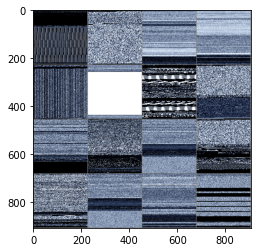

In [18]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))


In [19]:
# For 3-Channel Image print
print_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           pin_memory=True)

In [20]:
dataiter = iter(print_loader)
images, labels = dataiter.next()
print(labels)

tensor([10, 12,  6,  0, 11, 14, 17, 25])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])
(3, 228, 1810)
(228, 1810, 3)
torch.Size([8, 3, 224, 224])
torch.Size([3, 228, 1810])
Fasong  Hlux BrowseFox Adposhel HackKMS InstallCore Neshta Vilsel 


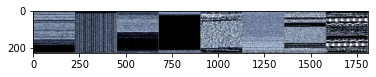

In [21]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(8)))


Count plot을 그려보자 

In [22]:
# How to list all subdirectories in a directory in Py

import os
root_dir = './malevis_train_val_224x224/train'

for file in os.listdir(root_dir):
    print(file)

Allaple
Autorun
Agent
Elex
Expiro
Androm
Adposhel
Dinwod
BrowseFox
Amonetize
InstallCore
MultiPlug
Neshta
HackKMS
Fasong
Other
Neoreklami
Injector
Regrun
Hlux
Stantinko
Vilsel
VBKrypt
Sality
VBA
Snarasite


In [23]:
import os

root_dir = './malevis_train_val_224x224/train'
malevis_dict = {}

for file in os.listdir(root_dir):
    num_file = len(os.listdir(os.path.join(root_dir, file)))
    malevis_dict[file] = num_file


print(malevis_dict)

{'Allaple': 350, 'Autorun': 350, 'Agent': 350, 'Elex': 350, 'Expiro': 350, 'Androm': 350, 'Adposhel': 350, 'Dinwod': 350, 'BrowseFox': 350, 'Amonetize': 350, 'InstallCore': 350, 'MultiPlug': 350, 'Neshta': 350, 'HackKMS': 350, 'Fasong': 350, 'Other': 350, 'Neoreklami': 350, 'Injector': 350, 'Regrun': 350, 'Hlux': 350, 'Stantinko': 350, 'Vilsel': 350, 'VBKrypt': 350, 'Sality': 350, 'VBA': 350, 'Snarasite': 350}


In [24]:
df = pd.DataFrame.from_dict(malevis_dict, orient='index', columns=['count'])
df = df.T
df.head()

,Allaple,Autorun,Agent,Elex,Expiro,Androm,Adposhel,Dinwod,BrowseFox,Amonetize,InstallCore,MultiPlug,Neshta,HackKMS,Fasong,Other,Neoreklami,Injector,Regrun,Hlux,Stantinko,Vilsel,VBKrypt,Sality,VBA,Snarasite
count,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350


### EDA
* 데이터 분포 시각화
* 일부 데이터 시각

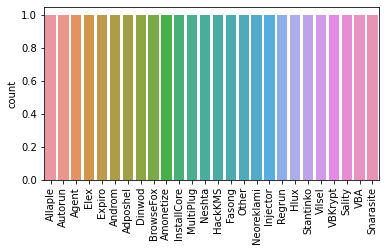

In [25]:
import seaborn as sns

plt.figure()
g = sns.countplot(data = df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.subplots_adjust(bottom=0.28)
plt.savefig('./num_of_samples_r90')
plt.show()

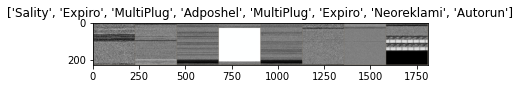

<Figure size 432x288 with 0 Axes>

In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.subplots_adjust(bottom=0.28)
    plt.savefig('./visualize_samples.png')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.
    plt.savefig('./visualize_samples_.png')


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(print_loader))
# print(inputs, classes)
class_name = trainset.classes

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name[x] for x in classes])

In [27]:
len([ 3, 17,  0,  5, 22, 15,  2,  9,  6,  9, 18, 11,  0,  6, 21,  6])

16

# 03. Model Architecture

* pre-trained ResNet-152
* Transfer Learning
* Fine-Tunning

## 합성곱 신경망 미세조정(fine-tunning)
* 미리 학습한 모델을 불러온 후 마지막의 완전 연결계층을 초기화한다
* Reference: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

In [28]:
# Reference: https://www.programcreek.com/python/example/108010/torchvision.models.resnet152

def get_pretrained_resnet(new_fc_dim=None):
    """
    Fetches a pretrained resnet model (downloading if necessary) and chops off the top linear
    layer. If new_fc_dim isn't None, then a new linear layer is added.
    :param new_fc_dim: 
    :return: 
    """

    resnet152 = models.resnet152(pretrained=True)
    # del resnet152.fc

    # num_ftrs
    # Reference: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html
    num_ftrs = resnet152.fc.in_features  
                                         # in_feature is the number of inputs for your linear layer:
                                         # https://discuss.pytorch.org/t/what-does-the-fc-in-feature-mean/4889
    print('print_num_ftrs: ', num_ftrs)

    if new_fc_dim is not None:  # 마지막 계층의 유닛 개수를 변경해준다.
                                # For Classification
        # resnet152.fc = nn.Linear(ENCODING_SIZE, new_fc_dim)
        
        resnet152.fc = nn.Linear(num_ftrs, new_fc_dim)

        # _init_fc(resnet152.fc)
    else:
        pass
        # resnet152.fc = lambda x:x

    return resnet152

In [29]:
resnet152 = get_pretrained_resnet(26)  # load pre-trained ResNet152
resnet152

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



print_num_ftrs:  2048


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
resnet152 = resnet152.to(device=('cuda:0' if torch.cuda.is_available() else 'cpu'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters(), lr=0.001)

### 하이퍼 파라미터 세팅

In [31]:
import argparse

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.net = resnet152
args.criterion = criterion
args.optim = optimizer

args.train_loader = train_loader
args.val_loader = val_loader
args.test_loader = test_loader

args.lr = 0.001
args.exp_lr_scheduler = lr_scheduler.StepLR(args.optim, step_size=10, gamma=0.1)  # 10 Epoch마다 0.1씩 학습률 감소
args.mm = 0.9
args.epoch = 100

print(args)

Namespace(criterion=CrossEntropyLoss(), epoch=100, exp_lr_scheduler=<torch.optim.lr_scheduler.StepLR object at 0x7f5236ffbdd8>, lr=0.001, mm=0.9, net=ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

## 03. Model Train, Validate, Test

학습 결과가 가장 좋은 모델만 저장하자(한 번 해보자!)

In [34]:
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader
dataloaders['test'] = test_loader

dataset_sizes = {'train': train_size, 
                 'val': val_size,
                 'test': test_size}

    

In [37]:
# Reference: 토치 튜토리얼
# https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):  # epoch의 default값은 25
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    
    # 모델 파라미터와 함께 loss/accuracy도 저장해주자
    global list_epoch
    global list_train_loss
    global list_val_loss

    global list_val_acc
    global list_test_acc
    global list_acc_epoch

    list_epoch= []
    list_train_loss = []
    list_val_loss = []
    
    list_train_acc = []
    list_val_acc = []
    list_test_acc = []
    list_acc_epoch = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖는다.
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # train이면 학습 모드로 설정
            else:
                model.eval()  # val이면 검증 모드로 설정

            running_loss = 0.0  # 현재 running_loss
            running_corrects = 0

            # 데이터 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 검사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파(Forward pass)
                # 학습시에만 연산 기록을 추적한다
                with torch.set_grad_enabled(phase=='train'):  # train이 아닌 경우에는 연산 기록 추적을 하지 않는구나!
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)  # It's because the loss given by CrossEntropy or other loss functions 
                                                              # is divided by the number of elements i.e. the reduction parameter is mean by default.
                running_corrects += torch.sum(preds == labels.data)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            elif phase == 'val':
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)
            elif phase == 'test':
                list_test_acc.append(epoch_acc)
                list_epoch.append(epoch)
                list_acc_epoch.append(epoch)

            print('{}: Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m{:.0f}'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # 가장 나은 모델의 가중치를 불러온다
    model.load_state_dict(best_model_wts)
    # 여기에 가장 나은 모델의 가중치만 저장해보자 - 20.12.15.Tue-
    # optimizer도 같이 저장한다
    torch.save(model.state_dict(), 'model_epoch{}.pth'.format(best_epoch+1))
    torch.save(optimizer.state_dict(), 'optim_epoch{}.pth'.format(best_epoch+1))

    return model

In [35]:
# args.__dict__

In [ ]:
model_ft = train_model(args.net, args.criterion, args.optim, args.exp_lr_scheduler, args.epoch)

Epoch 0/99
----------
train: Loss: 1.1524 Acc: 0.6864
val: Loss: 0.8199 Acc: 0.8066
test: Loss: 0.7327 Acc: 0.8209

Epoch 1/99
----------
train: Loss: 0.4657 Acc: 0.8701
val: Loss: 0.3750 Acc: 0.8956
test: Loss: 0.3521 Acc: 0.9055

Epoch 2/99
----------
train: Loss: 0.3219 Acc: 0.9084
val: Loss: 0.3950 Acc: 0.9077
test: Loss: 0.3437 Acc: 0.9198

Epoch 3/99
----------
train: Loss: 0.2779 Acc: 0.9191
val: Loss: 0.3420 Acc: 0.9066
test: Loss: 0.2962 Acc: 0.9110

Epoch 4/99
----------
train: Loss: 0.2187 Acc: 0.9357
val: Loss: 0.3135 Acc: 0.9066
test: Loss: 0.3353 Acc: 0.9088

Epoch 5/99
----------
train: Loss: 0.1705 Acc: 0.9477
val: Loss: 0.2753 Acc: 0.9363
test: Loss: 0.2371 Acc: 0.9418

Epoch 6/99
----------
train: Loss: 0.1480 Acc: 0.9549
val: Loss: 0.2272 Acc: 0.9385
test: Loss: 0.2376 Acc: 0.9462

Epoch 7/99
----------
train: Loss: 0.1264 Acc: 0.9626
val: Loss: 0.2302 Acc: 0.9451
test: Loss: 0.2507 Acc: 0.9396

Epoch 8/99
----------
train: Loss: 0.1525 Acc: 0.9547
val: Loss: 0.3516 

### 학습 결과 저장
* pickle파일로 학습 결과를 저장한다
* save_model_path = './results'

In [ ]:
import os
import pickle

def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

save_model_path = './results/'
make_dir(save_model_path)

results = {'list_epoch': list_epoch,
        'list_train_loss': list_train_loss,
        'list_val_loss': list_val_loss,
        'list_train_acc': list_train_acc,
        'list_val_acc': list_val_acc ,
        'list_test_acc': list_test_acc ,
        'list_acc_epoch': list_acc_epoch}

with open(save_model_path+'res-152_ft_results', 'wb') as fw:
    pickle.dump(results, fw)
print("Experiment results saved!")

In [ ]:
# load data
with open(save_model_path+'res-152_ft_results', 'rb') as fr:
    results_dict = pickle.load(fr)

# show data
print(results_dict)

In [ ]:
fig = plt.figure(figsize=(15,12))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(results_dict['list_epoch'], results_dict['list_train_loss'], label='train_loss')
ax1.plot(results_dict['list_epoch'], results_dict['list_val_loss'], '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(results_dict['list_acc_epoch'], results_dict['list_train_acc'], marker='x', label='Train Accuracy ')
ax2.plot(results_dict['list_acc_epoch'], results_dict['list_val_acc'], marker='x', label='Val Accuracy')

ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('Train Accuracy vs Val Accuracy')

# ====== Metric Fluctuation ====== #
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(results_dict['list_acc_epoch'], results_dict['list_train_acc'], marker='x', label='Train Accuracy ')
ax3.plot(results_dict['list_acc_epoch'], results_dict['list_test_acc'], marker='x', label='Test Accuracy')

ax3.set_xlabel('epoch')
ax3.set_ylabel('Acc')
ax3.grid()
ax3.legend()
ax3.set_title('Train Accuracy vs Test Accuracy')

# ====== Metric Fluctuation ====== #
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(results_dict['list_acc_epoch'], results_dict['list_train_acc'], marker='x', label='Train Accuracy ')
ax4.plot(results_dict['list_acc_epoch'], results_dict['list_val_acc'], marker='x', label='Val Accuracy')
ax4.plot(results_dict['list_acc_epoch'], results_dict['list_test_acc'], marker='x', label='Test Accuracy')

ax4.set_xlabel('epoch')
ax4.set_ylabel('Acc')
ax4.grid()
ax4.legend()
ax4.set_title('Train Accuracy Val Accuracy vs Test Accuracy')

plt.savefig(save_model_path + './resnet152_FE.png')
print("fig saved!")
plt.show()